In [1]:
import numpy as np
import sys
sys.path.append('../../')
sys.path.append('../../pyfos/')
from pyfos.models.feedforward import build_feedforward
from pyfos.generic.optimizer import gd_optimizer
from pyfos.generic.regularizers import gaus_prior
from functools import partial 
from pyfos.tc.simple import  simple_tc
from pyfos.tc.cv import  cv_tc
from pyfos.hyperoptimizers.random_search import random_optimize
from pyfos.hyperoptimizers.no_optimize import no_optimize
import theano
%matplotlib inline
import matplotlib.pylab as plt
import random
import theano.tensor as T

In [2]:
X_train, X_test = np.load('../../../data/W_X_Tr.npy'), np.load('../../../data/W_X_Test.npy')
Y_train, Y_test = np.load('../../../data/W_Y_Tr.npy'), np.load('../../../data/W_Y_Test.npy')

param_num = X_train.shape[1] * 50 + 50 + 50  + 1

lr = theano.shared(10**(-5))
alphas = theano.shared(np.array([1.0, 1.0]))
real_alphas = T.concatenate([T.repeat(alphas[0],  X_train.shape[1] * 50 + 50)   , T.repeat(alphas[1],  50 + 1) ])
optimizer = partial(gd_optimizer, learning_rate=lr)
model_build = partial(build_feedforward,  structure = [X_train.shape[1],50, 1],   init_sigmas=[0.001]*3, nonlinearity=lambda x:T.nnet.relu(x), log_alphas =real_alphas, bias=True)

#for test
alphas.set_value(np.array([12., 1.0]))
print alphas.eval()
print real_alphas.eval()

[ 12.   1.]
[ 12.  12.  12. ...,   1.   1.   1.]


In [3]:
def choicer():
    result = []
    for i in xrange(param_num):
        a1  = np.random.choice(range(-5, 5))
        a2 =np.random.choice(range(-5, 5))
        
        
    return np.array([a1,a2])
print choicer()

[-3  3]


In [5]:
bests = []
for trial in range(5):
    tc =  partial(cv_tc, k =4,  batch_size=25)
    print 'attemp'
    bests.append( random_optimize(tc, model_build, optimizer, 50, 10**4, X_train, Y_train,  [alphas] ,
     [choicer], verbose=1000000))
    print bests[-1].history[-1][-1]

attemp
hyperparams values: [-1. -4.]
trial 0 iteration 0, internal loss=-1084046.59504
score -1086257.31139 vs best -inf
hyperparams values: [ 2.  3.]
trial 1 iteration 0, internal loss=-1174105.59939
score -1086249.70904 vs best -1086257.31139
hyperparams values: [ 3. -5.]
trial 2 iteration 0, internal loss=-1203584.68768
score -1086286.35953 vs best -1086249.70904
hyperparams values: [-2.  0.]
trial 3 iteration 0, internal loss=-1054347.54312
score -1086250.86451 vs best -1086249.70904
hyperparams values: [-4. -1.]
trial 4 iteration 0, internal loss=-994526.126803
score -1086251.32047 vs best -1086249.70904
hyperparams values: [ 0.  3.]
trial 5 iteration 0, internal loss=-1114278.76798
score -1086249.74808 vs best -1086249.70904
hyperparams values: [ 0. -3.]
trial 6 iteration 0, internal loss=-1113998.55618
score -1086254.32144 vs best -1086249.70904
hyperparams values: [-4.  3.]
trial 7 iteration 0, internal loss=-994736.451789
score -1086251.31328 vs best -1086249.70904
hyperparams

KeyboardInterrupt: 

In [46]:
bests

[]

In [ ]:

import cPickle
#with open('results_cv_rand.pckl','rb') as inp:
#    bests = cPickle.load(inp)

for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
    plt.plot(history)
#plt.ylim((-100, -80))
plt.xlim((1,50))

import cPickle
with open('results_cv_rand.pckl','wb') as out:
    cPickle.dump(bests, out)

print bests

In [12]:
bests[0].history[1]

([array([ 5.75646273,  1.15129255]), 0.01], array(-inf))

In [6]:
import theano.tensor as T
X = T.matrix()
result = []
models = []
predicts = []

for m in xrange(4):
    models.append(model_build(dataset_size=100))
    predict = models[m].predict_var(X)
    predicts.append(theano.function([X], predict))
for b in bests:
    scores = [b.history[i][1] for i in xrange(len(b.history))]
    best = np.argmax(scores)
    
    for m in xrange(4):
        #print b.history[best][2][m]
        models[m].params.set_value(b.history[best][2][m])
        result.append(np.mean((predicts[m](X_test)[:,0]-Y_test)**2))
        print result[-1]
    """
    bests.append( random_optimize(partial(cv_tc, k =4,  batch_size=75), model_build, optimizer, 50, 10, X_train, Y_train,  [alphas, lr] ,
     [alpha_ranges, lr_ranges], verbose=100))
    X = T.matrix()    
    model = model_build(dataset_size=100)
    
    
    """

print np.mean(result)
print np.std(result)

9.43914336962e-05
0.000124289005293
0.00129238139516
0.000242562662603
0.000779013165161
0.0102724095201
0.000206747922337
0.000140740432021
0.000132832862326
8.03570899432e-06
0.00749791590336
6.75131708431e-05
0.003461156779
0.000129756949236
0.000222773236192
0.000242858305185
7.31068395923e-06
0.000446081971565
2.10039527387e-05
0.00498557348802
0.000127393299536
0.000344975987004
0.00193295197259
1.12403631093e-05
0.00110372549492
0.000169369711448
8.88501579515e-05
0.000371158334277
5.25537631743e-05
0.000169072496902
6.99270861379e-05
0.000118547148409
0.00031077408314
0.000360231067999
0.00288808340749
0.00124557541155
0.0080222197081
0.000376121747349
0.000469794144926
0.000297591329386
0.00025797182711
0.00567665490985
2.50256902362e-05
2.5725705823e-05
3.9389787181e-05
0.000166544706471
0.000305865928779
5.53252217421e-05
0.000103489182896
0.000183979775623
0.000195866374435
0.000208717300477
2.41616115724e-05
0.000922038736434
0.000177551325219
0.00052912656389
0.0009803654

In [11]:
best_values = []
for b in bests:
    history = []
    for i in xrange(0, len(b.history)):
        
        best_value = max([h[1] for h in b.history[:i+1]])
        
        history.append(best_value)
        best_values.append(history[-1])
print np.mean(best_values)

-116.59428108


[([array([  31.6227766 ,  316.22776602]), 0.001], array(-127.64285224474986)),
 ([array([ 10.        ,   3.16227766]), 0.01], array(-162.5087255392545)),
 ([array([ 31.6227766 ,   3.16227766]), 0.01], array(-2.7627426873481633e+42)),
 ([array([  10.,  100.]), 0.005], array(-124.3719052719263)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-1.2198974168241432e+41)),
 ([array([ 316.22776602,    1.        ]), 0.001], array(-122.78697142872564)),
 ([array([ 1.,  1.]), 0.01], array(-2.048288202990528e+45)),
 ([array([ 316.22776602,   10.        ]), 0.02], array(nan)),
 ([array([   1.,  100.]), 0.005], array(-127.03124347465777)),
 ([array([  3.16227766,  31.6227766 ]), 0.01], array(-3.879875247817619e+79))]

In [33]:
for i in bests:
    print np.array(i.best_values[0])**2

[ 1.  1.]
[ 1.  1.]
[ 10.   1.]
[ 1.  1.]
[ 1.  1.]


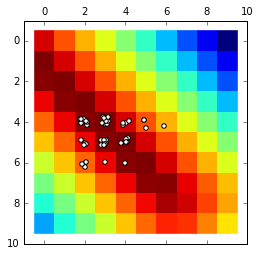

In [7]:
plt.matshow(matrix.T)
for i in bests:
    i = i.best_values[0]
    i = np.log10(np.exp(2*i))
    
    plt.scatter(i[0]+np.random.randn(1)*0.1,i[1]+np.random.randn(1)*0.1, c='w')

In [7]:
model = model_build(dataset_size=100)

In [9]:
import theano.tensor as T

In [28]:
X,Y = T.matrix(), T.vector()

In [29]:
cost = model.cost(X,Y)

In [35]:
f = theano.function([X,Y], cost)
print cost
f2 = theano.function([X,Y], T.grad(cost, model.params))
model.params.set_value([ 102.5926679 ,    0.23016751])

Elemwise{add,no_inplace}.0


In [36]:
#f(np.random.randn(100,2), np.random.randn(100))

f2(np.random.randn(100,2), np.random.randn(100))

array([ -1.02592668e+08,  -2.30167510e+05])